In [25]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread


In [26]:
def window_sizes(sigma):
    # choose the window size to be the
    # smallest odd integer greater than
    # or equal to 6*sigma+1
    w = np.ceil(6*sigma+1)
    try:
        # when sigma is an array/matrix
        w[w % 2 == 0]+=1
        return w.astype(int)
    except:
        # when sigma is a single value
        if w % 2 == 0:
            w += 1
        return int(w)



In [27]:
def zero_pad_image(image, w):
    # get the shape of the image
    [x, y] = np.shape(image)
    # how much to zero pad by to maintain the shape
    d = w//2
    # array of zeros
    zero_padded_image = np.zeros((x+2*d, y+2*d))
    # fill the middle of it with the given image
    zero_padded_image[d:-d, d:-d] = image
    return zero_padded_image

In [29]:
def gaussian_kernel(w, sigma):
    d = w//2
    # blur kernel of the required size
    blur_kernel = np.zeros((w, w))
    if w == 1:
        # to prevent division by zero errors when the sigma value is zero
        # when sigma is zero, the Gaussian kernel is essentially [[1]]
        return np.ones((w, w))
    for i in range(w):
        for j in range(w):
            # skipping the 1/(2*np.pi*sigma**2) constant as it will cancel
            # out anyways in the sum and calculating it again and again is
            # just useless computation
            blur_kernel[i, j] = np.exp((-(i-d)**2-(j-d)**2)/(2*(sigma**2)))
    # divide by the sum of the entries so that the entries of the kernel
    # sum up to 1. This is necessary to ensure that we do not dim or brighten
    # the image we are convolving
    blur_kernel = blur_kernel/np.sum(blur_kernel)
    return blur_kernel

In [30]:
def get_A_B(N, s_0, s_N_by_2):
    A = s_N_by_2
    B = N**2/(2*np.log(A/s_0))
    return A, B


In [31]:
def sigma_mat(A, B, N):
    a = np.arange(N)
    # use meshgrid to avoid double for loops
    # [x,y] = np.meshgrid(a,a)
    # The equivalent code using double for loops is
    final_array = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            final_array[i,j] = A*(np.exp(-((i-N/2)**2+(j-N/2)**2)/B))
    return final_array

In [32]:
def convolution_2D(image, sigma, correlation=True):
    # The correlation parameter is to distinguish between
    # correlation and convolution. For a Gaussian kernel, it
    # makes no difference as the symmetry of the Gaussian kernel means
    # correlation and convolution give the same results
    [x, y] = np.shape(image)
    w = window_sizes(sigma)
    d = w//2
    # if the kernel is of size (1,1), just return the original image
    if d == 0:
        return image
    padded_image = zero_pad_image(image, w)
    # get the Gaussian kernel
    blur_kernel = gaussian_kernel(w, sigma)
    if not correlation:
        # flip the kernel if we are going to perform convolution
        blur_kernel = blur_kernel[::-1, ::-1]
    filtered_image = np.zeros((x, y))
    print(f"Performing space-invariant blur for sigma={sigma}...")
    for i in range(d, x+d):
        for j in range(d, y+d):
            # Extract the required image patch, multiply it with the kernel,
            # sum up the values and store it in the filtered_image array
            patch = padded_image[i-d:i+d+1, j-d:j+d+1]
            filtered_image[i-d, j-d] = np.sum(blur_kernel*patch)
    return filtered_image

In [33]:
def space_variant_blur(image, sigma_matrix):
    # get the shape of the image
    [x, y] = np.shape(image)
    # ensure that the image and blur matrix have the same size
    assert np.shape(image) == np.shape(sigma_matrix), "sigma matrix and image of different shape"
    # get the window sizes for each sigma value
    w_vals = window_sizes(sigma_matrix)
    # get the maximum window size
    max_w = np.max(w_vals)
    d_w = max_w//2
    # pad the image with appropriate zeroes for convolving with a kernel of the maximum size
    # a better way to do it is to take the maximum kernel size only for those sigma values
    # which lie at the edges of the blur matrix. It does not make much difference to the final result,
    # however as the padded zeroes will be removed finally and are there only to make the implementation
    # of space varying blur simpler
    padded_image = zero_pad_image(image, max_w)
    # maintain a dictionary of kernels to avoid recomputing them for various sigma values
    kernels = {}
    # create the canvas of zeros for the final image
    final_image = np.zeros_like(padded_image)
    print(f"Performing space-varying blur...")
    for i in range(d_w, x+d_w):
        for j in range(d_w, x+d_w):
            # get the appropriate sigma value and image intensity
            sigma = sigma_matrix[i-d_w, j-d_w]
            intensity = image[i-d_w, j-d_w]
            # if the kernel for a given sigma is already calculated, retrieve it along with
            # the corresponding w and d values
            if sigma in kernels.keys():
                w, d, kernel = kernels[sigma]
            # else calculate that kernel, w, and d values and save them
            else:
                w = w_vals[i-d_w, j-d_w]
                d=w//2
                kernel = gaussian_kernel(w, sigma)
                kernels[sigma] = (w, d, kernel)
            # multiply the kernel with the image intensity at that coordinate
            # and add that value to the canvas
            final_image[i-d:i+d+1, j-d:j+d+1] += intensity*kernel
    # return the canvas by cropping out the zero padded regions
    return final_image[d_w:-d_w, d_w:-d_w]

In [34]:
def plotter(image, blurred_image, title_1, title_2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,12), constrained_layout=True)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax1.imshow(image, 'gray')
    ax2.imshow(blurred_image, 'gray')
    ax1.title.set_text(title_1)
    plt.axis('off')
    ax2.title.set_text(title_2)
    plt.axis('off')
    plt.show()

<ipython-input-35-807910773545>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imread('Globe.png')


Performing space-varying blur...


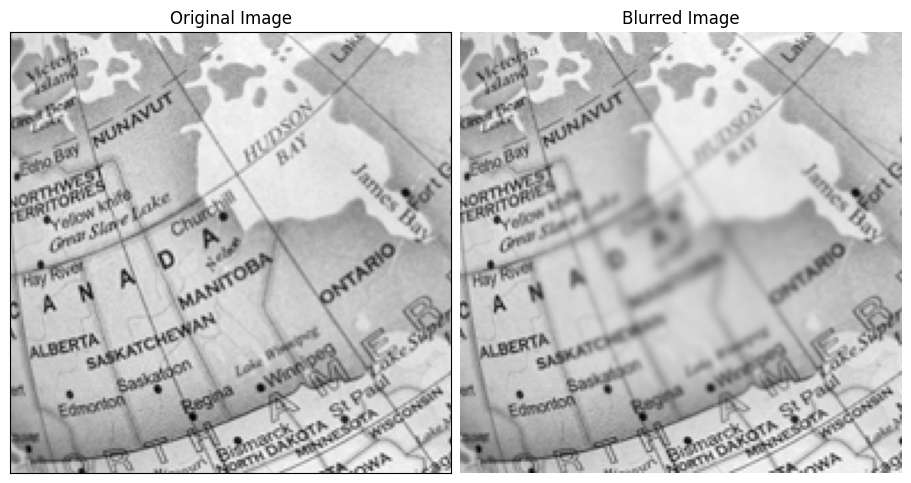

In [35]:
img1 = imread('Globe.png')
# get the image shape
[x, y] = np.shape(img1)
# initial conditions
s_mid = 2.0
s_0 = 0.01
# get A and B values
[A, B] = get_A_B(x, s_0, s_mid)
# form the blur matrix
sigma_matrix = sigma_mat(A, B, x)
# get the blurred image
blurred = space_variant_blur(img1, sigma_matrix)

plotter(img1, blurred, "Original Image", "Blurred Image")

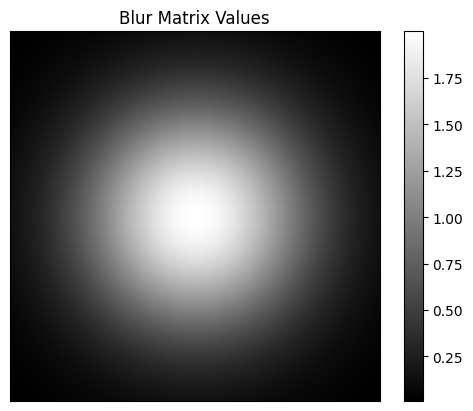

In [36]:
plt.imshow(sigma_matrix, 'gray')
plt.xticks([])
plt.yticks([])
plt.title("Blur Matrix Values")
plt.colorbar()
plt.show()

In [37]:
img2 = imread("Nautilus.png")
# get the shape of the image
[x_, y_] = np.shape(img2)
# sigma as given in the assignment PDF
sigma = 1.0
# constant blur matrix
sigma_matrix = sigma*np.ones((x_, y_), dtype=float)
# space varying blur with a constant blur matrix
blurred_1 = space_variant_blur(img2, sigma_matrix)
# space invariant blur
blurred_2 = convolution_2D(img2, sigma)

<ipython-input-37-57f760c19808>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imread("Nautilus.png")


Performing space-varying blur...
Performing space-invariant blur for sigma=1.0...


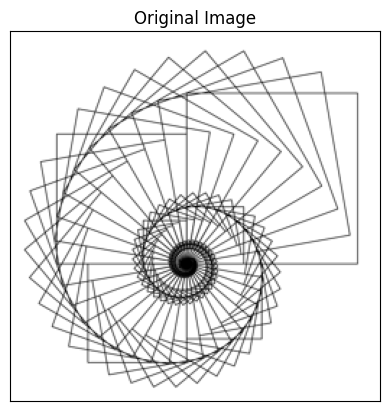

In [38]:
plt.imshow(img2, 'gray')
plt.xticks([])
plt.yticks([])
plt.title("Original Image")
plt.show()

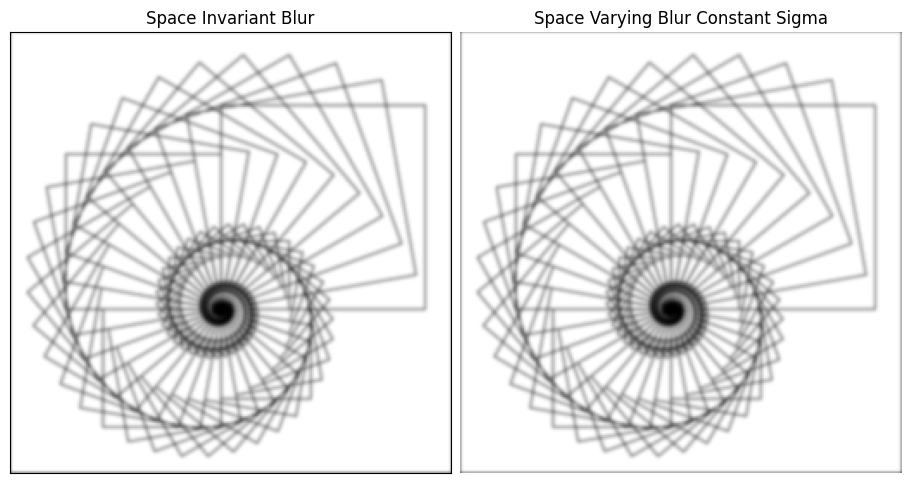

In [39]:
plotter(blurred_1, blurred_2, "Space Invariant Blur", "Space Varying Blur Constant Sigma")


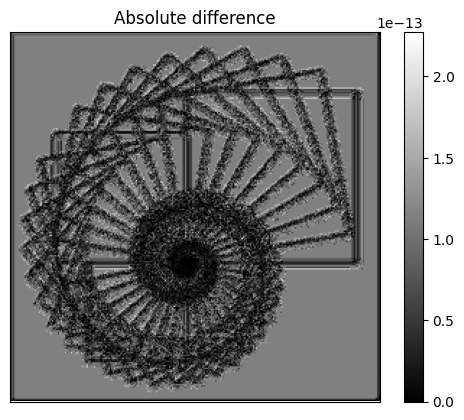

In [40]:
plt.imshow(np.abs(blurred_1-blurred_2), 'gray')
plt.xticks([])
plt.yticks([])
plt.title("Absolute difference")
plt.colorbar()
plt.show()